# Clustering Algorithms: k-means and DBSCAN

## k-means

* Let’s train a k-means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob:

In [14]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [
        [ 0.2,  2.3],
        [-1.5 ,  2.3],
        [-2.8,  1.8],
        [-2.8,  2.8],
        [-2.8,  1.3]
    ]
)

blob_std = np.array(
    [
        0.4,
        0.3,
        0.1,
        0.1,
        0.1
    ]
)

X, y = make_blobs(
    n_samples=2000,
    centers=blob_centers,
    cluster_std=blob_std,
    random_state=7
)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

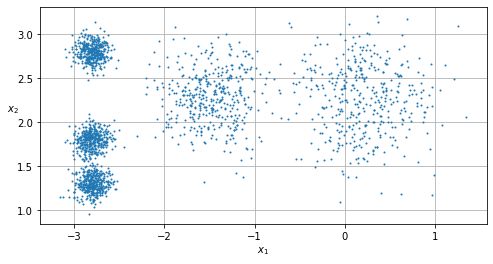

In [15]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()


In [16]:
y_pred

array([0, 0, 4, ..., 3, 1, 0])

In [17]:
y_pred is kmeans.labels_

True

* For centroids:

In [18]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

In [19]:
X_new = np.array(
    [
        [0, 2],
        [3, 2],
        [-3, 3],
        [-3, 2.5]
    ]
    
)

kmeans.predict(X_new)

array([4, 4, 3, 3])

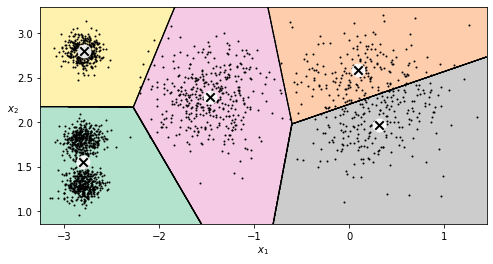

In [20]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

* In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [21]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

## Centroid initialization methods

* If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [22]:
good_init = np.array(
    [
        [-3, 3],
        [-3, 2],
        [-3, 1],
        [-1, 2],
        [0, 2]
    ]
)

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)

kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

* The number of random initializations is controlled by the n_init hyperparameter: by default it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call fit(), and Scikit-Learn keeps the best solution. But how exactly does it know which solution is the best? It uses a performance metric! That metric is called the model’s ``inertia``, which is the sum of the squared distances between the instances and their closest centroids.

In [23]:
kmeans.inertia_

211.5985372581684

In [24]:
kmeans.score(X)

-211.59853725816836

* The score() method returns the negative inertia (it’s negative because a predictor’s score() method must always respect Scikit-Learn’s “greater is better” rule: if a predictor is better than another, its score() method should return a greater score)

## Accelerated k-means and mini-batch k-means

* Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm (typically by a factor of three to four) and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the MiniBatchKMeans class, which you can use just like the KMeans class:

In [25]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

## Finding the optimal number of clusters

In [26]:
kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k3.fit(X)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)
kmeans_k8.fit(X)

KMeans(n_init=10, random_state=42)

In [27]:
kmeans_k3.inertia_

653.216719002155

In [28]:
kmeans_k8.inertia_

119.22484592677111

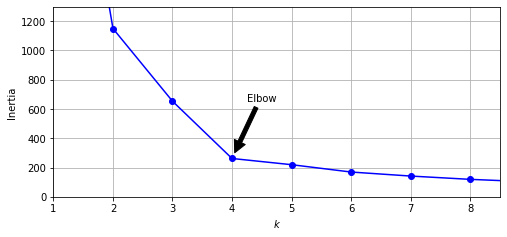

In [29]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()

* Another approach is to look at the ``silhouette score``

In [30]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

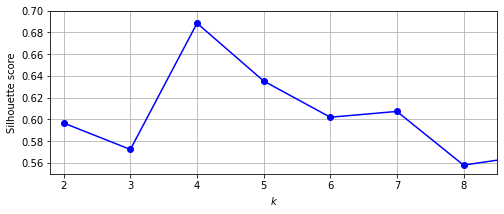

In [31]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()

## Using Clustering for Image Segmentation

In [32]:
#import PIL

#image = np.asarray(PIL.Image.open(filepath))
#image.shape

In [33]:
#X = image.reshape(-1, 3)
#kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
#segmented_img = kmeans.cluster_centers_[kmeans.labels_]
#segmented_img = segmented_img.reshape(image.shape)

## Using Clustering for Semi-Supervised Learning

* Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. In this section, we’ll use the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9. First, let’s load and split the dataset

In [34]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

* We will pretend we only have labels for 50 instances. To get a baseline performance, let’s train a logistic regression model on these 50 labeled instances:

In [35]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50 #Meanwhile we're really pretending :)

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

* We can then measure the accuracy of this model on the test set (note that the test set must be labeled):

In [36]:
log_reg.score(X_test, y_test)

0.7581863979848866

* The model’s accuracy is just 74.8%. That’s not great: indeed, if you try training the model on the full training set, you will find that it will reach about 90.7% accuracy. Let’s see how we can do better. First, let’s cluster the training set into 50 clusters. Then, for each cluster, we’ll find the image closest to the centroid. We’ll call these images the representative images:

In [37]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans.fit(X_train)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

* the 50 representative images:

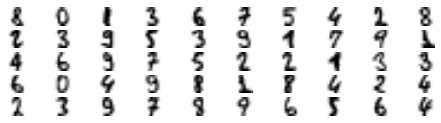

In [38]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

* Let’s look at each image and manually label them:

In [39]:
y_representative_digits = np.array([
    8, 0, 1, 3, 6, 7, 5, 4, 2, 8,
    2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
    4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
    6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
    2, 3, 9, 7, 8, 9, 6, 5, 6, 4
])

* Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better:

In [40]:
log_reg = LogisticRegression(max_iter=10_000)

log_reg.fit(X_representative_digits, y_representative_digits)

log_reg.score(X_test, y_test)

0.8337531486146096

* we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

In [41]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

* Now let’s train the model again and look at its performance:

In [42]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [43]:
log_reg.score(X_test, y_test)

0.8690176322418136

* Let’s see if we can do even better by ignoring the 1% of instances that are farthest from their cluster center: this should eliminate some outliers. The following code first computes the distance from each instance to its closest cluster center, then for each cluster it sets the 1% largest distances to –1. Lastly, it creates a set without these instances marked with a –1 distance:

In [44]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

* Now let’s train the model again on this partially propagated dataset and see what accuracy we get:

In [45]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8614609571788413

In [46]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9614814814814815

## DBSCAN

* The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)b
dbscan.fit(X)

DBSCAN(eps=0.05)

* The labels of all the instances are now available in the labels_ instance variable:

In [48]:
dbscan.labels_

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

* Notice that some instances have a cluster index equal to –1, which means that they are considered as anomalies by the algorithm. The indices of the core instances are available in the core_sample_indices_ instance variable, and the core instances themselves are available in the components_ instance variable:

In [51]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [52]:
dbscan.components_[:10]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

* This clustering is represented in the lefthand plot of Figure 9-14. As you can see, it identified quite a lot of anomalies, plus seven different clusters. How disappointing! Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get the clustering on the right, which looks perfect. Let’s continue with this model.

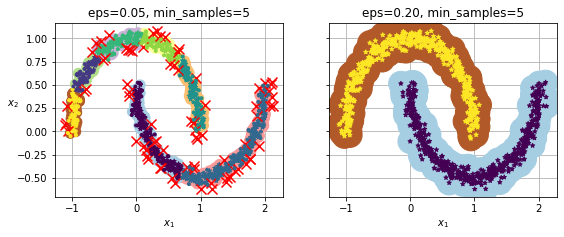

In [53]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

In [54]:
dbscan = dbscan2

* Surprisingly, the DBSCAN class does not have a predict() method, although it has a fit_predict() method. In other words, it cannot predict which cluster a new instance belongs to.

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

* Now, given a few new instances, we can predict which clusters they most likely belong to and even estimate a probability for each cluster:

In [56]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [57]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

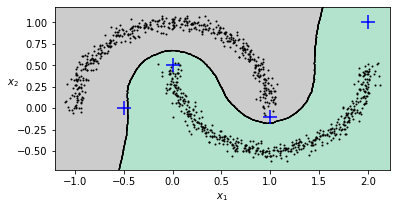

In [58]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)